In [308]:
import keras
import numpy as np
import tensorflow as tf
from keras.datasets import mnist
from matplotlib import pyplot as plt

In [309]:
(x_train, labels_train), (x_test, labels_test) = mnist.load_data()

5

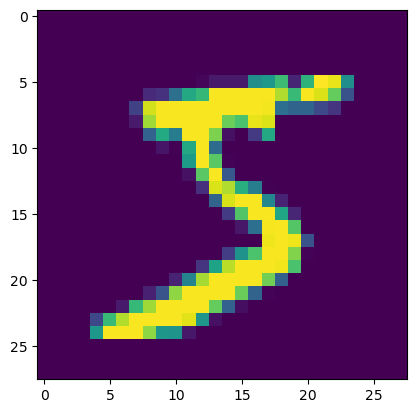

In [310]:
plt.imshow(x_train[0])
labels_train[0]

In [311]:
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
x_train.shape

(60000, 28, 28)

# Reshape the data to fit the model

In [312]:
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

# One-hot encoding

In [313]:
from keras.utils import to_categorical
y_train = to_categorical(labels_train, 10)
y_test = to_categorical(labels_test, 10)

# Data augmentation

In [314]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=20, 
    width_shift_range=0.1, 
    height_shift_range=0.1, 
    zoom_range=0.1,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode='nearest')

# Define the CNN model

In [315]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, BatchNormalization, Dropout
model = Sequential()

model.add(Conv2D(32, (5, 5), activation='relu', input_shape=(28, 28, 1)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (5, 5), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.summary()

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_86 (Conv2D)          (None, 24, 24, 6)         156       
                                                                 
 max_pooling2d_60 (MaxPoolin  (None, 12, 12, 6)        0         
 g2D)                                                            
                                                                 
 conv2d_87 (Conv2D)          (None, 8, 8, 16)          2416      
                                                                 
 max_pooling2d_61 (MaxPoolin  (None, 4, 4, 16)         0         
 g2D)                                                            
                                                                 
 flatten_24 (Flatten)        (None, 256)               0         
                                                                 
 dense_53 (Dense)            (None, 120)             

In [316]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['accuracy'])

# K-fold cross-validation

In [ ]:
def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * 0.1

In [317]:
from sklearn.model_selection import KFold
kfold = KFold(n_splits=5, shuffle=True)

In [318]:
# Train and evaluate the model with k-fold cross-validation
from sklearn.metrics import precision_score, f1_score, recall_score
from keras.callbacks import EarlyStopping
from keras.callbacks import LearningRateScheduler


historys = []
accuracies = []
losses = []
precisions = []
f1_scores = []
recalls = []

for fold, (train_indices, val_indices) in enumerate(kfold.split(x_train)):
    print('Fold:', fold+1)
    x_train_fold = x_train[train_indices]
    y_train_fold = y_train[train_indices]
    x_val_fold = x_train[val_indices]
    y_val_fold = y_train[val_indices]
    
    # Fit the model with data augmentation
    history = model.fit(datagen.flow(x_train_fold, y_train_fold, batch_size=512),
                        epochs=10,
                        validation_data=(x_val_fold, y_val_fold),
                        callbacks=[EarlyStopping(patience=5), LearningRateScheduler(scheduler)])
    
    historys.append(history)

    # Evaluate the model on the test set
    loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
    y_pred = np.argmax(model.predict(x_test), axis=1)
    y_true = np.argmax(y_test, axis=1)
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')

    print('Accuracy:', accuracy)
    print('Loss:', loss)
    print('Precision:', precision)
    print('Recall:', recall)
    print('F1-score:', f1)

    accuracies.append(accuracy)
    losses.append(loss)
    recalls.append(recall)
    precisions.append(precision)
    f1_scores.append(f1)

print('Average accuracy:', np.mean(accuracies))
print('Average loss:', np.mean(losses))
print('Average precision:', np.mean(precisions))
print('Average recall:', np.mean(recalls))
print('Average F1-score:', np.mean(f1_scores))

Fold: 1
Epoch 1/10


2023-02-20 12:52:59.316500: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


94/94 [==============================] - ETA: 0s - loss: 1.1685 - accuracy: 0.6258

2023-02-20 12:53:04.414974: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


94/94 [==============================] - 9s 89ms/step - loss: 1.1685 - accuracy: 0.6258 - val_loss: 0.2873 - val_accuracy: 0.9175
Epoch 2/10
94/94 [==============================] - 7s 78ms/step - loss: 0.4293 - accuracy: 0.8698 - val_loss: 0.1707 - val_accuracy: 0.9473
Epoch 3/10
94/94 [==============================] - 8s 80ms/step - loss: 0.3096 - accuracy: 0.9062 - val_loss: 0.1296 - val_accuracy: 0.9605
Epoch 4/10
94/94 [==============================] - 8s 83ms/step - loss: 0.2598 - accuracy: 0.9219 - val_loss: 0.1023 - val_accuracy: 0.9680
Epoch 5/10
94/94 [==============================] - 7s 80ms/step - loss: 0.2208 - accuracy: 0.9337 - val_loss: 0.0910 - val_accuracy: 0.9711
Epoch 6/10
94/94 [==============================] - 8s 80ms/step - loss: 0.1934 - accuracy: 0.9421 - val_loss: 0.0865 - val_accuracy: 0.9722
Epoch 7/10
94/94 [==============================] - 7s 78ms/step - loss: 0.1843 - accuracy: 0.9437 - val_loss: 0.0801 - val_accuracy: 0.9747
Epoch 8/10
94/94 [======

2023-02-20 12:54:15.613269: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 39/313 [==>...........................] - ETA: 0s

2023-02-20 12:54:19.125870: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 1s 3ms/step
Accuracy: 0.9748000502586365
Loss: 0.0735606774687767
Precision: 0.9753899730566772
Recall: 0.9743868572247388
F1-score: 0.974528129466837
Fold: 2
Epoch 1/10
94/94 [==============================] - 7s 79ms/step - loss: 0.1402 - accuracy: 0.9568 - val_loss: 0.0730 - val_accuracy: 0.9780
Epoch 2/10
94/94 [==============================] - 7s 79ms/step - loss: 0.1329 - accuracy: 0.9587 - val_loss: 0.0667 - val_accuracy: 0.9791
Epoch 3/10
94/94 [==============================] - 7s 78ms/step - loss: 0.1311 - accuracy: 0.9603 - val_loss: 0.0961 - val_accuracy: 0.9704
Epoch 4/10
94/94 [==============================] - 7s 78ms/step - loss: 0.1235 - accuracy: 0.9613 - val_loss: 0.0665 - val_accuracy: 0.9796
Epoch 5/10
94/94 [==============================] - 7s 78ms/step - loss: 0.1152 - accuracy: 0.9639 - val_loss: 0.0698 - val_accuracy: 0.9788
Epoch 6/10
94/94 [==============================] - 7s 78ms/step - loss: 0.1113 - accuracy: 0

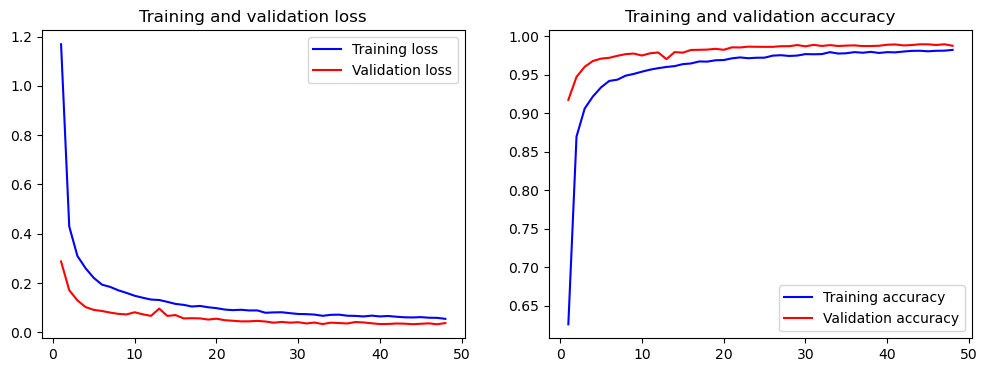

In [319]:
losses = [loss for history in historys for loss in history.history['loss']]
val_losses = [val_loss for history in historys for val_loss in history.history['val_loss']]
accuracies = [accuracy for history in historys for accuracy in history.history['accuracy']]
val_accuracies = [val_accuracy for history in historys for val_accuracy in history.history['val_accuracy']]

epochs = range(1, len(losses) + 1)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, losses, 'b', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, accuracies, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.show()
    

In [320]:
model.save("network_for_mnist.h5")